In [1]:
import numpy as np
import matplotlib.pylab as plt

Import function

In [2]:
from simulate_spectrometer_signal import *

### Create some electron Bunch

In [3]:
s = np.linspace(-100,100,200)*1e-6 # in m
sigma_s = 10e-6 #width of bunch

def gauss(x, sigma):
    """
    Gauss Function with amplitude 1
    """
    return np.exp(-x**2/2/sigma**2)

profile =gauss(s, sigma_s)
charge = 250e-12 # Bunch charge in C
current = profile/ np.trapz(profile, x = s/3e8)*charge # get actual current by normalizing to charge

Text(0, 0.5, 'I (kA)')

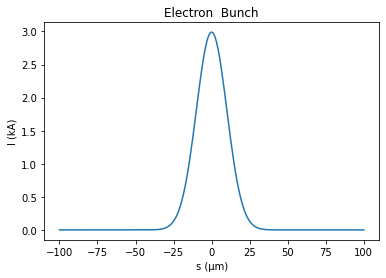

In [4]:
plt.figure()
plt.title('Electron  Bunch')
plt.plot(s*1e6, current*1e-3)
plt.xlabel('s (µm)')
plt.ylabel('I (kA)')

### Get corresponding spectrometer signal

In [5]:
frequencies, formfactors, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots = 10, which_set = 'both')

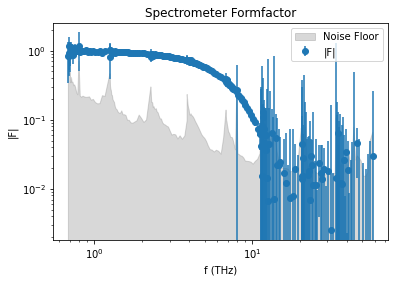

In [6]:
plt.figure()
plt.title('Spectrometer Formfactor')
plt.errorbar(frequencies*1e-12,formfactors, yerr = formfactor_noise, fmt='o', label = '|F|')
plt.fill_between(frequencies*1e-12, np.zeros(np.size(detlim)), y2 = detlim, label = 'Noise Floor', alpha = 0.3, color = 'gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f (THz)')
plt.ylabel('|F|')
plt.legend()

This is the simulated signal of the spectrometer (including noise) it gathers when averaging over 10 shots for both grating sets. In reality we only have one grating set at a time. This can be set with the keyword for which_set: 'low', 'high', 'both'.

### Let's see how it looks like if we take a funnier shape and change the bunch length

In [7]:
def unsym_gauss(x, sigma1,sigma2):
    """Creates an unsymmetric gaussian 
    """
    data = np.zeros(np.size(x))
    data[x>=0]  = gauss(x[x>=0],sigma1)
    data[x<0] = gauss(x [x<0], sigma2)
    return data
sigma1s = np.array([7,5,15,3])*1e-6
sigma2s = np.array([7,20,15,10])*1e-6
all_profiles = np.asarray([unsym_gauss(s,sigma1s[i],sigma2s[i]) for i in np.arange(np.size(sigma1s))])
all_currents = all_profiles/np.trapz(all_profiles, x = s/3e8,axis=1)[:,np.newaxis] *charge
#centering
#shifts=np.sum(all_currents*np.arange(np.size(s)),axis=1)/np.sum(all_currents,axis=1)-199/2
#all_currents = np.roll(all_currents, +shifts.astype(int), axis=0)
#shifts

Text(0, 0.5, 'I (kA)')

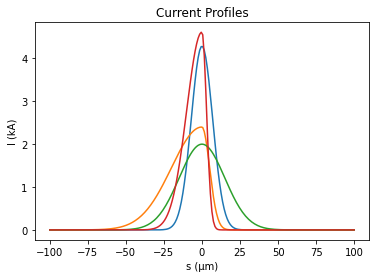

In [8]:
plt.figure()
plt.title('Current Profiles')
for i in np.arange(np.shape(all_currents)[0]):
    plt.plot(s*1e6, all_currents[i]*1e-3)
plt.xlabel('s (µm)')
plt.ylabel('I (kA)')

Get the spectrometer data

Text(0, 0.5, '|F|')

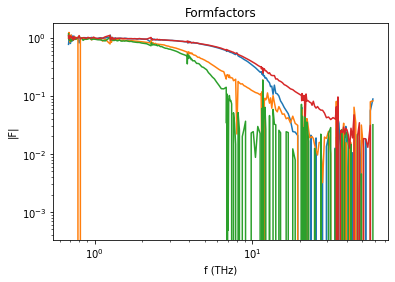

In [9]:
all_data = np.asarray([get_crisp_signal(s, current, n_shots = 10, which_set = 'both')[1:] for current in all_currents])
all_ff = all_data[:,0]
all_ff_noise = all_data[:,1]

plt.figure()
for i in np.arange(sigma1s.size):
    plt.loglog(frequencies*1e-12,all_ff[i])
plt.title('Formfactors')
plt.xlabel('f (THz)')
plt.ylabel('|F|')

### And how it would look lik in real life? So only gratings for high or low frequencies and single shot.

Text(0, 0.5, '|F|')

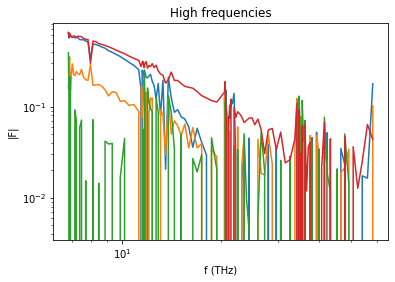

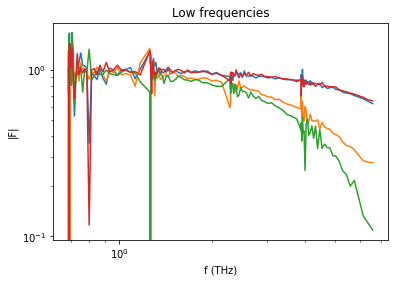

In [10]:
all_ff_high = np.asarray([get_crisp_signal(s, current, which_set = 'high')[1] for current in all_currents])
all_ff_low = np.asarray([get_crisp_signal(s, current, which_set = 'low')[1] for current in all_currents])

plt.figure()
plt.title('High frequencies')
for i in np.arange(sigma1s.size):
    plt.loglog(frequencies[120:]*1e-12,all_ff_high[i])
plt.xlabel('f (THz)')
plt.ylabel('|F|')

plt.figure()
plt.title('Low frequencies')
for i in np.arange(sigma1s.size):
    plt.loglog(frequencies[:120]*1e-12,all_ff_low[i])
plt.xlabel('f (THz)')
plt.ylabel('|F|')

Some comments on this: That there are these jumps espically at the very low and high frequencies of the spectrometer is due to the sensitivity of the spectrometer. The sensitivity is rather bad at the start and end of the spectrum. It also descreases at the edges of one grating. Therefore the measured formfactor gets more noisy at some points in the low frequency plot

# Form factor clean up 

In order to do something with the simulated (or actually measured) spectrometer signal, we have to clean it up a little bit. That means smoothing the data and remove non-valid data points. All of this is done within the reconstruction module. 

In [11]:
from reconstruction_module import *

First let's clean up the data by simply calling the function

(0.2, 70)

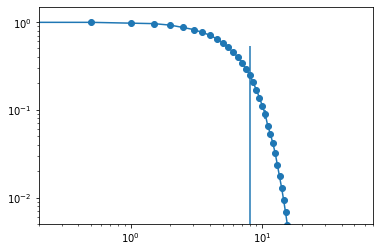

In [12]:
newfreqs, newff, newffnoise = cleanup_formfactor(frequencies, formfactors, formfactor_noise, detlim, channels_to_remove = [])
plt.figure()
plt.errorbar(newfreqs*1e-12, newff, yerr = newffnoise, fmt = 'o-')
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-3,1.5])
plt.xlim([0.2,70])

And we can also do the current reconstruction with this module

In [13]:
recon_time, recon_current, t_rms = master_recon(frequencies, formfactors, formfactor_noise, detlim, charge, method = 'KKstart',
                 channels_to_remove = [], show_plots = False)

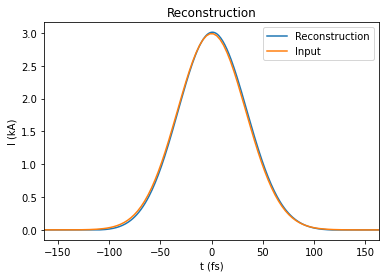

In [14]:
plt.figure()
plt.title('Reconstruction')
plt.plot(recon_time*1e15, recon_current*1e-3, label = 'Reconstruction')
plt.plot(s/3e8*1e15, current*1e-3, label = 'Input')
plt.xlabel('t (fs)')
plt.ylabel('I (kA)')
plt.xlim([-5*t_rms*1e15, 5*t_rms*1e15])
plt.legend()

So that worked pretty great ! 

## Test with all bunches from above

(0.2, 70)

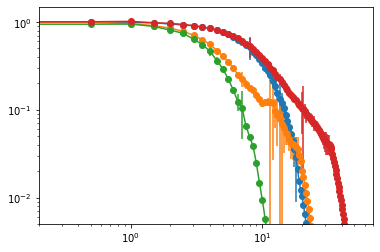

In [15]:
plt.figure()
for i in np.arange(sigma1s.size):
    this_freq, this_ff, this_ff_noise = cleanup_formfactor(frequencies, all_ff[i], all_ff_noise[i], detlim, charge)
    plt.errorbar(this_freq*1e-12, this_ff, yerr = this_ff_noise, fmt = 'o-')
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-3,1.5])
plt.xlim([0.2,70])

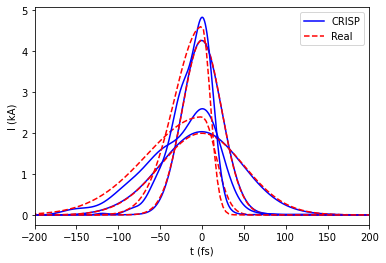

In [16]:
plt.figure()
for i in np.arange(sigma1s.size):
    this_recon_time, this_recon_current, this_t_rms = master_recon(frequencies, all_ff[i], all_ff_noise[i], detlim, charge, method = 'KKstart',
                 channels_to_remove = [], show_plots = False)
    this_recon_time = this_recon_time - this_recon_time[np.argmax(this_recon_current)] # just for better comparison
    plt.plot(this_recon_time*1e15, this_recon_current*1e-3, 'blue')
    plt.plot(s/3e8*1e15, all_currents[i]*1e-3,'r--')
plt.xlabel('t (fs)')
plt.ylabel('I (kA)')
plt.xlim([-200,200])
plt.legend(['CRISP', 'Real'])

Nice!

### Try a real measurement. Recorded with save_shaper_traces.py and calculate_formfactor.py

In [17]:
from scipy.io import loadmat

In [18]:
data = loadmat('formfactor_14_28_25_l1_-11.0.mat',squeeze_me = True)
crisp_freqs = data['frequencies']
crisp_ff = data['formfactors'] # mean
crisp_ff_noise = data['formfactors_err'] # shot-to-shot fluctuations
crisp_det_lim = data['det_limit'] # noise floor
crisp_charge = data['charge']

In [19]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'frequencies', 'shot_formfactors', 'formfactors', 'formfactors_err', 'det_limit', 'shot_det_limit', 'charge'])

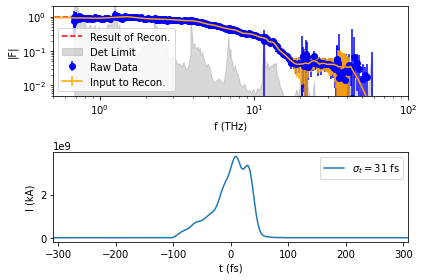

In [20]:
crisp_recon_time, crisp_recon_current, crisp_t_rms = master_recon(crisp_freqs, crisp_ff, crisp_ff_noise, crisp_det_lim, crisp_charge,
                 channels_to_remove = [15,135], show_plots = True)

## Shortest possible bunches and structures to resolve

Text(0, 0.5, '|F|')

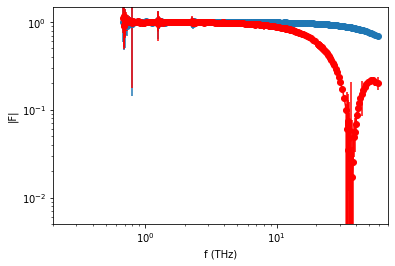

In [21]:
s = np.linspace(-10,10,400)*1e-6
short_profile =gauss(s, .7e-6)
short_rectangle = np.zeros_like(s)
short_rectangle[np.abs(s)<4e-6] = 1
short_current = short_profile/ np.trapz(short_profile, x = s/3e8)*charge # get actual current by normalizing to charge
rectangle_current = short_rectangle/ np.trapz(short_rectangle, x = s/3e8)*charge # get actual current by normalizing to charge
frequencies, formfactors, formfactor_noise, detlim = get_crisp_signal(s, short_current, n_shots = 30, which_set = 'both')
frequencies, formfactors_rec, formfactor_noise_rec, detlim_rec = get_crisp_signal(s, rectangle_current, n_shots = 30, which_set = 'both')
plt.figure()
plt.errorbar(frequencies*1e-12, formfactors, yerr = formfactor_noise, fmt = 'o-')
plt.errorbar(frequencies*1e-12, formfactors_rec, yerr = formfactor_noise_rec, fmt = 'ro-')
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-3,1.5])
plt.xlim([0.2,70])
plt.xlabel('f (THz)')
plt.ylabel('|F|')

In [22]:
recon_time, recon_current, t_rms = master_recon(frequencies, formfactors, formfactor_noise, detlim, charge, method = 'KKstart',
                 channels_to_remove = [], show_plots = False, wanted_time_res = 0.1e-15, wanted_time_frame = 0.5e-12)
recon_time_rec, recon_current_rec, t_rms_rec = master_recon(frequencies, formfactors_rec, formfactor_noise_rec, detlim_rec, charge, method = 'KKstart',
                 channels_to_remove = [], show_plots = False, wanted_time_res = 0.1e-15, wanted_time_frame = 0.5e-12)

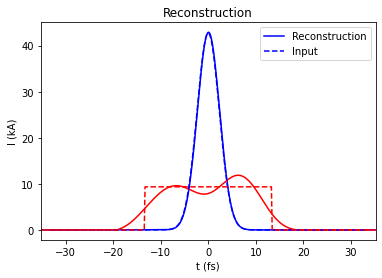

In [23]:
plt.figure()
plt.title('Reconstruction')
plt.plot(recon_time*1e15, recon_current*1e-3, 'b',label = 'Reconstruction')
plt.plot(recon_time_rec*1e15, recon_current_rec*1e-3, 'r')
plt.plot(s/3e8*1e15, short_current*1e-3, 'b--',label = 'Input')
plt.plot(s/3e8*1e15, rectangle_current*1e-3, 'r--')
plt.xlabel('t (fs)')
plt.ylabel('I (kA)')
plt.xlim([-15*t_rms*1e15, 15*t_rms*1e15])
plt.legend()

and how about structures?

Text(0, 0.5, '|F|')

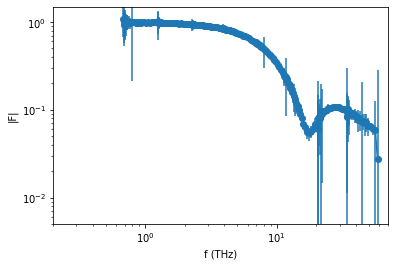

In [24]:
s = np.linspace(-50,50,400)*1e-6
baseprofile = unsym_gauss(s, 10e-6,5e-6)
spike = gauss(s-7e-6,1e-6 )
spike_profile = baseprofile + spike
spike_current = spike_profile/ np.trapz(spike_profile, x = s/3e8)*charge # get actual current by normalizing to charge
frequencies, formfactors, formfactor_noise, detlim = get_crisp_signal(s, spike_current, n_shots = 100, which_set = 'both')
#shorter_spike  
spike_short = gauss(s+7e-6,0.3e-6 )
spike_profile_short = baseprofile + spike_short
spike_current_short = spike_profile_short/ np.trapz(spike_profile_short, x = s/3e8)*charge # get actual current by normalizing to charge
frequencies_short, formfactors_short, formfactor_noise_short, detlim_short = get_crisp_signal(s, spike_current_short, n_shots = 100, which_set = 'both')
plt.figure()
plt.errorbar(frequencies*1e-12, formfactors, yerr = formfactor_noise, fmt = 'o-')
#plt.errorbar(frequencies*1e-12, formfactors_short, yerr = formfactor_noise_short, fmt = 'ro-')
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-3,1.5])
plt.xlim([0.2,70])
plt.xlabel('f (THz)')
plt.ylabel('|F|')

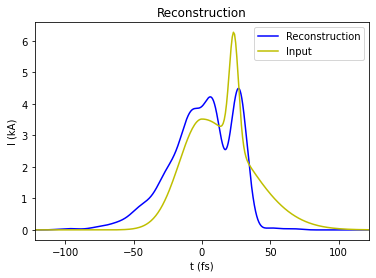

In [25]:
recon_time, recon_current, t_rms = master_recon(frequencies, formfactors, formfactor_noise, detlim, charge, method = 'KKstart',
                 channels_to_remove = [], show_plots = False, wanted_time_res = 0.1e-15, wanted_time_frame = 0.5e-12)
recon_time_short, recon_current_short, t_rms_short = master_recon(frequencies, formfactors_short, formfactor_noise_short, detlim_short, charge, method = 'KKstart',
                 channels_to_remove = [], show_plots = False, wanted_time_res = 0.1e-15, wanted_time_frame = 0.5e-12)
plt.figure()
plt.title('Reconstruction')
plt.plot(recon_time*1e15, recon_current*1e-3, 'b',label = 'Reconstruction')
plt.plot(s/3e8*1e15, spike_current*1e-3, 'y',label = 'Input')
#plt.plot(-recon_time_short*1e15, recon_current_short*1e-3, 'b--')
#plt.plot(s/3e8*1e15, spike_current_short*1e-3, 'y--')
plt.xlabel('t (fs)')
plt.ylabel('I (kA)')
plt.xlim([-5*t_rms*1e15, 5*t_rms*1e15])
plt.legend()

Structures and bunches of roughly 3-4 fs can still be resolved